# Basic SVOL

Stochastic Volatility Model: https://mc-stan.org/docs/stan-users-guide/stochastic-volatility-models.html

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm, truncnorm, norm
import statsmodels.api as sm
import pyjags
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

## Sampling functions

In [2]:
'''
  JAGS sampling
  params:
    dataset, proposal distribution parameters, parameters for jags model, sampling iterations, # of chains, burn-in iterations, initial values for sampling
  returns:
    samples
'''
def jags_sampling(dataset, prop1, prop2, parameters, iters, chains, burn_in, init_vals = None):

  # JAGS sampling
  jags_data = {"y": list(dataset), "N": len(dataset), "prop1": prop1, "prop2": prop2}
  jags_model_string = '''
    model {
      mu ~ dnorm(0, 1/prop1)         # variance is inverse of the precision parameter
      phi ~ dunif(-1, 1)
      sigma ~ dnorm(0, 1/prop2) T(0,)

      h[1] ~ dnorm(mu, sqrt(1 - pow(phi, 2))/sigma )
      for (i in 2:N) {
        h[i] ~ dnorm(mu + phi * (h[i-1] - mu), 1/sigma)
      }

      for (j in 1:N) {
        y[j] ~ dnorm(0, 1/exp(h[j]/2) )
      }
    }
  '''

  jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=chains, adapt=burn_in, init=init_vals)
  jags_samples = jags_model.sample(iterations=iters, vars=parameters)

  # chains
  return [jags_samples[p][0] for p in parameters]

In [3]:
'''
  check convergence via Gelman-Rubin statistic
  extract posterior distributions' information
  params:
    chains of all the posterior data
  returns:
    posterior distribution information
'''
def extract_posterior_data(sample_chains, parameters, chains, iters, burn_in):

  # checking convergence

  sample_chains_np = np.array(sample_chains)
  posterior_info = {}
  print(f'\nCHAINS: {chains}, ITERS: {iters}, BURN-IN: {burn_in}')

  for p in range(len(parameters)):

    # means
    _chains = sample_chains_np[p].T
    _x = np.mean(_chains)
    chain_means = np.mean(_chains, axis=1)

    # Gelman-Rubin Statistic
    varB = (iters/(chains-1))*np.sum([(_x - x)**2 for x in chain_means])
    varW = sum( [ sum( [(chain_means[i] - s)**2 for s in _chains[i]] )/(iters - 1) for i in range(len(_chains)) ] ) / chains
    varM = ((iters-1)*varW + varB)/iters
    R = np.sqrt(varM/varW)

    # mode & 95% interval
    chain_modes = []
    chain_intervals = []

    for ch in _chains:

      kde = sm.nonparametric.KDEUnivariate(ch)
      kde.fit(bw=1.5)
      xs = np.linspace(np.min(ch), np.max(ch), 1000)
      ys = [kde.evaluate(x) for x in xs]
      chain_modes.append(xs[np.argmax(ys)])

      sorted_chain = np.sort(ch)
      n = len(sorted_chain)
      interval_width = int(n * 0.95)
      lower_bound = sorted_chain[(n - interval_width)//2]
      upper_bound = sorted_chain[-((n - interval_width)//2 + 1)]
      chain_intervals.append([lower_bound, upper_bound])


    posterior_info[parameters[p]] = {
      'means': chain_means,
      'modes': chain_modes,
      'intervals': chain_intervals, 
      'R': R
    }

  return posterior_info


In [4]:
'''
  plot posterior distributions & samples by steps
'''
def plot_samples(sample_chains, parameters, chains):

  fig, axs = plt.subplots(len(parameters), 2, figsize=(10, 8))
  axs[0, 0].set_title('Samples\' distribution: value vs. probability density')
  axs[0, 1].set_title('Sampling steps: Step# vs. sample value')
  colors = ['brown', 'indigo']

  for p in range(len(parameters)):

    for c in range(chains):
      # samples' distribution
      sns.kdeplot(data=sample_chains[p][:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.7)
      # sampling steps
      sns.lineplot(data=sample_chains[p][:, c], ax=axs[p, 1], color=colors[c], alpha=0.7)

    # axs[p, 0].set_facecolor('black')
    axs[p, 0].set_ylabel(parameters[p])
    # axs[p, 1].set_facecolor('black')

  fig.suptitle(f'MCMC sampling with pyjags with {chains} chains')
  plt.tight_layout()
  plt.show()

## Data set

- Data curation for historical data of stock & cryptocurrency prices from [Investing.com](https://www.investing.com/)

In [5]:
# plug in stock data set

df = pd.read_csv('datasets/<>.csv')

## Data inspection

In [6]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,07/31/2017,33.91,33.89,34.09,33.79,31.21K,0.12%
1,08/01/2017,34.35,34.00,34.50,33.95,40.57K,1.30%
2,08/02/2017,34.84,34.68,34.92,34.43,41.89K,1.43%
3,08/03/2017,35.51,34.98,35.68,34.62,87.39K,1.92%
4,08/04/2017,35.31,35.85,35.90,35.20,122.87K,-0.56%


In [7]:
df.describe()

,Price,Open,High,Low
count,1522.000000,1522.000000,1522.000000,1522.000000
mean,63.813173,63.828541,64.717451,62.909783
std,20.537573,20.562103,20.711432,20.393859
min,31.700000,29.150000,32.370000,28.550000
25%,47.577500,47.555000,48.500000,46.847500
50%,61.200000,61.200000,62.050000,60.270000
75%,76.455000,76.607500,77.775000,75.537500
max,114.700000,115.050000,115.400000,114.100000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1522 non-null   object 
 1   Price     1522 non-null   float64
 2   Open      1522 non-null   float64
 3   High      1522 non-null   float64
 4   Low       1522 non-null   float64
 5   Vol.      1519 non-null   object 
 6   Change %  1522 non-null   object 
dtypes: float64(4), object(3)
memory usage: 83.4+ KB


In [9]:
'''
  convert string to datetime
  change formats as required for the dates
  '%m/%d/%Y'
  '%b %d, %Y'
'''

df['Date'] = df['Date'].apply(lambda dt: datetime.strptime(dt, "%m/%d/%Y"))

In [10]:
# sorting data chronologically

df.sort_values(by='Date', inplace=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-07-31,33.91,33.89,34.09,33.79,31.21K,0.12%
1,2017-08-01,34.35,34.00,34.50,33.95,40.57K,1.30%
2,2017-08-02,34.84,34.68,34.92,34.43,41.89K,1.43%
3,2017-08-03,35.51,34.98,35.68,34.62,87.39K,1.92%
4,2017-08-04,35.31,35.85,35.90,35.20,122.87K,-0.56%


In [11]:
# if price column doesn't have float data type

if df['Price'].dtype != 'float':

  # if string
  if df['Price'].dtype == 'object':
    df['Price'] = df['Price'].apply(lambda x: x.replace(',', ''))
  df = df.astype({'Price': 'float'})

In [12]:
# get asset returns from closing prices

# yt = 100 * (log(Pt) - log(Pt-1))
df['Asset_return'] = np.log(df['Price'].shift(-1) / df['Price']) * 100
df['Asset_return'] = df['Asset_return'].shift(1)

df[['Asset_return']].head()

,Asset_return
0,NaN
1,1.289206
2,1.416413
3,1.904819
4,-0.564814


In [13]:
# removing the first column with price NaN

df = df.iloc[1:]

In [14]:
df[['Asset_return']].head()

,Asset_return
1,1.289206
2,1.416413
3,1.904819
4,-0.564814
5,0.874107


## Data split

We try to identify phases of high & low volatility

In [15]:
SPLIT=18

In [16]:
breakpoints = np.linspace(0, df.shape[0], SPLIT + 1).astype(int)
breakpoints

array([   0,   84,  169,  253,  338,  422,  507,  591,  676,  760,  845,
        929, 1014, 1098, 1183, 1267, 1352, 1436, 1521])

In [17]:
# data frame slices
dfs = []

for i in range(SPLIT):
  dfs.append( df[breakpoints[i]:breakpoints[i+1]].copy() )

In [18]:
# have asset returns mean-corrected for each slice

print('Means of asset return data for each slice (mean-corrected):')

for j in range(SPLIT):

  sl_mean = dfs[j][['Asset_return']].mean()
  dfs[j]['Asset_return'] = dfs[j]['Asset_return'].apply(lambda a: a - sl_mean)

  print(f'slice #{j+1}: {np.mean(dfs[j][["Asset_return"]].to_numpy())}')

Means of asset return data for each slice (mean-corrected):
slice #1: -8.921435019309294e-18
slice #2: -4.767428282213907e-17
slice #3: -2.6433881538694202e-17
slice #4: 1.3583905242472505e-16
slice #5: 1.586032892321652e-17
slice #6: -5.224578939412501e-18
slice #7: -2.7755575615628914e-17
slice #8: -1.0449157878825003e-17
slice #9: 2.9077269692563625e-17
slice #10: 0.0
slice #11: -5.28677630773884e-18
slice #12: 2.44902137784961e-17
slice #13: -5.551115123125783e-17
slice #14: 9.143013143971877e-18
slice #15: -7.401486830834377e-17
slice #16: -5.224578939412501e-18
slice #17: 9.516197353929913e-17
slice #18: -5.4858078863831267e-17


## Sampling

In [19]:
########## Random initial values & setting proposal distribution paramters ###########

returns = []
sds = []
mlvs = []
pers = []
shocks = []

print('Initializers:')

for k in range(SPLIT):

  returns.append( dfs[k][['Asset_return']].to_numpy().flatten() )
  sds.append( np.std(returns[k]) )

  # Mean log volatility(mu): draw randomly from a normal distribution with mean 0, SD of logarithmic returns
  mlvs.append( np.random.normal(loc=0, scale=sds[k]) )

  # Persistence of volatility(phi): draw randomly from a uniform distribution between 0 to 1
  pers.append( np.random.uniform(low=-1.0, high=1.0) )

  # Shock scale(sigma) distribution tends to be more heavy-tailed than the swing in prices itself
  # We draw from distribution twice as wide as that for mlv
  shocks.append( truncnorm.rvs(a=0, b=float('inf'), loc=0, scale=2*sds[k]) )

  print(f'''Slice #{k+1}:
    mu: {mlvs[k]}
    phi: {pers[k]}
    sigma: {shocks[k]}''')


Initializers:
Slice #1:
    mu: -1.2520686206685117
    phi: 0.3586973086353977
    sigma: 1.0417352787426384
Slice #2:
    mu: -2.9629001673336783
    phi: 0.3098337716156152
    sigma: 0.019465421323143727
Slice #3:
    mu: 1.2713464216063501
    phi: 0.28195003064994517
    sigma: 8.073035999860988
Slice #4:
    mu: -1.096579849321724
    phi: 0.03429534087072117
    sigma: 4.061921209437168
Slice #5:
    mu: 1.6360545235923152
    phi: 0.44403594192736917
    sigma: 1.500336211930664
Slice #6:
    mu: -1.088483049433752
    phi: 0.9704822587893807
    sigma: 2.0186297200277252
Slice #7:
    mu: -3.5276707690749474
    phi: 0.4320743663585318
    sigma: 0.847418917811504
Slice #8:
    mu: 0.3727448528358553
    phi: -0.4699214430888603
    sigma: 11.15744678227224
Slice #9:
    mu: 5.044165959774075
    phi: -0.9251930076572965
    sigma: 1.518041271827189
Slice #10:
    mu: -1.5550490520330875
    phi: 0.2024154722732523
    sigma: 1.6209136435217524
Slice #11:
    mu: -1.805310612

In [20]:
# sampling configs
ITERS=6000
CHAINS=2
BURN_IN=1000

In [21]:
# Sampling for all slices

parameters = ['mu', 'phi', 'sigma']
posteriors = []

for s in range(SPLIT):

  init_vals = {'mu': mlvs[s], 'phi': pers[s], 'sigma': shocks[s]}
  sample_chains = jags_sampling(dataset=returns[s], prop1=sds[s]**2, prop2=(2*sds[s])**2, parameters=parameters, iters=ITERS, chains=CHAINS, burn_in=BURN_IN, init_vals=init_vals)
  posterior_info = extract_posterior_data(sample_chains, parameters, ITERS, CHAINS, BURN_IN)
  posteriors.append(posterior_info)
  
  print(f'Slice #{s+1}:')
  for p in parameters:
    print(f'{p}:')
    for m, v in posterior_info[p].items():
      print(f'{m}: {v}')
  print('-------------\n')


adapting: iterations 2000 of 2000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 12000 of 12000, elapsed 0:00:04, remaining 0:00:00

CHAINS: 6000, ITERS: 2, BURN-IN: 1000
Slice #1:
mu:
means: [0.49297931 0.46566645]
modes: [0.4977323039681538, 0.46827220558725835]
intervals: [[-0.44971866142661665, 1.301301557174913], [-0.41882067698498526, 1.2611778554328605]]
R: 0.707106899491382
phi:
means: [0.34554853 0.26805884]
modes: [0.35072762029768345, 0.2724926211615759]
intervals: [[-0.3994691413454369, 0.9029047071957474], [-0.49065186842670294, 0.8119223737889146]]
R: 0.7071082655895159
sigma:
means: [1.62044377 1.86662792]
modes: [1.498934706239949, 1.711402793316858]
intervals: [[0.22462902427351386, 3.8404869536349233], [0.39424310938782886, 4.5075794125972655]]
R: 0.7071085126230349
-------------

adapting: iterations 2000 of 2000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 12000 of 12000, elapsed 0:00:02, remaining 0:00:00

CHAINS: 6000, ITERS: 2, BURN-IN: 1000

## Visualization

In [22]:
# pick chain for data
CHAIN_NUM=0

mus = []
phis = []
sigmas = []
intvls = []

for pstr in posteriors:
  mus.append(pstr['mu']['modes'][CHAIN_NUM])
  phis.append(pstr['phi']['modes'][CHAIN_NUM])

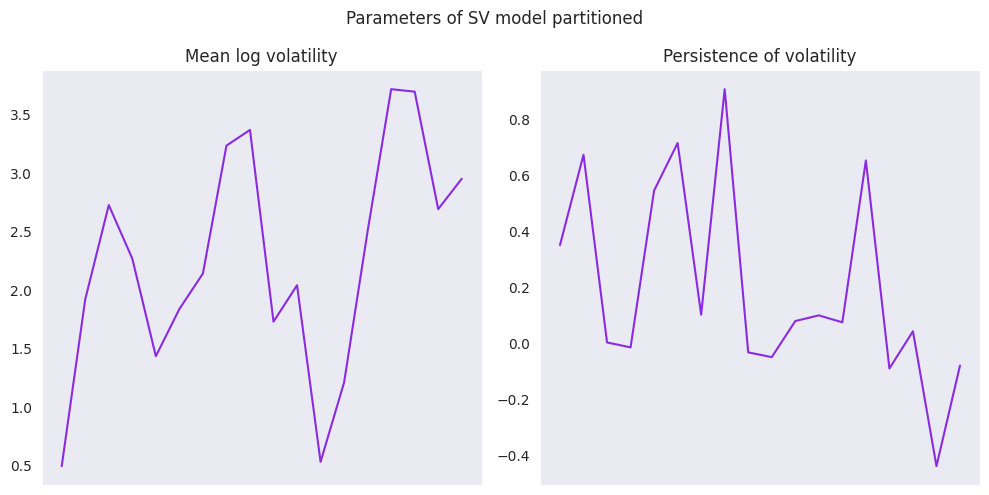

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=mus, markers="o", ax=axs[0], color="blueviolet")
sns.lineplot(data=phis, markers="o", ax=axs[1], color="blueviolet")

axs[0].set(title="Mean log volatility", xticks=[])
axs[1].set(title="Persistence of volatility", xticks=[])

fig.suptitle('Parameters of SV model partitioned')
plt.tight_layout()